In [2]:
%matplotlib inline
import emcee
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time, math
import torch
from tqdm import tqdm
from torch.multiprocessing import Pool#, set_start_method
from getdist import plots, MCSamples
import pymultinest
import getdist

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet

In [3]:
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [5]:
cosmo_prior = np.array([[66.5, 75.5],
                        [0.10782, 0.13178],
                        [0.0211375, 0.0233625],
                        [1.1885e-9, 2.031e-9],#[2.4752, 3.7128],
                        [1.806, 2.04],
                        [-2.962, 0.458]])

cosmo_fid = np.array([67.8,0.1190,0.02215,2.207e-9,1.9485,-0.5387])
print((cosmo_fid[1] + cosmo_fid[2] + 0.00064) / (cosmo_fid[0]/100.)**2)

gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}
redshift = 0.5

0.3084510228765848


In [6]:
# load in the mcmc chain from file
N    = 60000
NDIM = 6
N_sub = N
file1 = np.load(data_dir+"mcmc_chains_T0.npz")
file2 = np.load(data_dir+"mcmc_chains_Gaussian_Varied.npz")
file3 = np.load(data_dir+"mcmc_chains_Cholesky_Varied.npz")
file4 = np.load(data_dir+"mcmc_chains_SSC_Varied.npz")
file5 = np.load(data_dir+"mcmc_chains_G_emulate_Varied.npz")
file6 = np.load(data_dir+"mcmc_chains_Fixed_Far.npz")

chain_fixed = file1["chain"]
chain_fixed_far = file5["chain"]
chain_varied_G = file2["chain"]
chain_varied_G_emulated = file5["chain"]
chain_varied_C = file3["chain"]
chain_varied_SSC = file4["chain"]

chain_fixed[:,3] = np.exp(chain_fixed[:,3]) / 1e10
chain_fixed_far[:,3] = np.exp(chain_fixed_far[:,3]) / 1e10
chain_varied_G[:,3] = np.exp(chain_varied_G[:,3]) / 1e10
chain_varied_G_emulated[:,3] = np.exp(chain_varied_G_emulated[:,3]) / 1e10
chain_varied_C[:,3] = np.exp(chain_varied_C[:,3]) / 1e10
chain_varied_SSC[:,3] = np.exp(chain_varied_SSC[:,3]) / 1e10

rate_T0 = file1["rate"]
rate_varied_G = file2["rate"]
rate_varied_C = file3["rate"]
rate_varied_SSC = file4["rate"]
lkl_T0 = file1["lkl"]
lkl_varied_G = file2["lkl"]
lkl_varied_C = file3["lkl"]
lkl_varied_SSC = file4["lkl"]

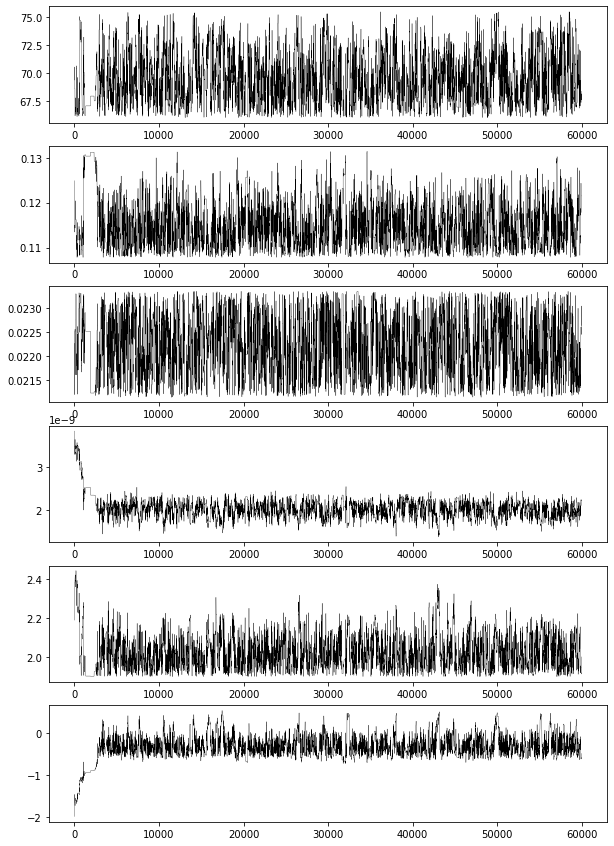

In [7]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain_fixed[:,i].T, 'k-', lw=0.3)
plt.show()  

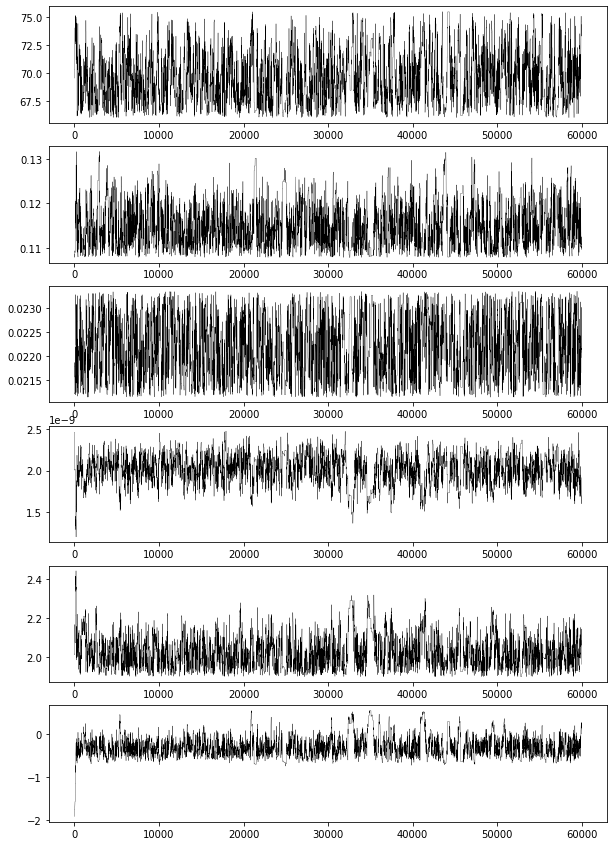

In [8]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain_varied_G[:N_sub,i].T, 'k-', lw=0.3)
plt.show()  

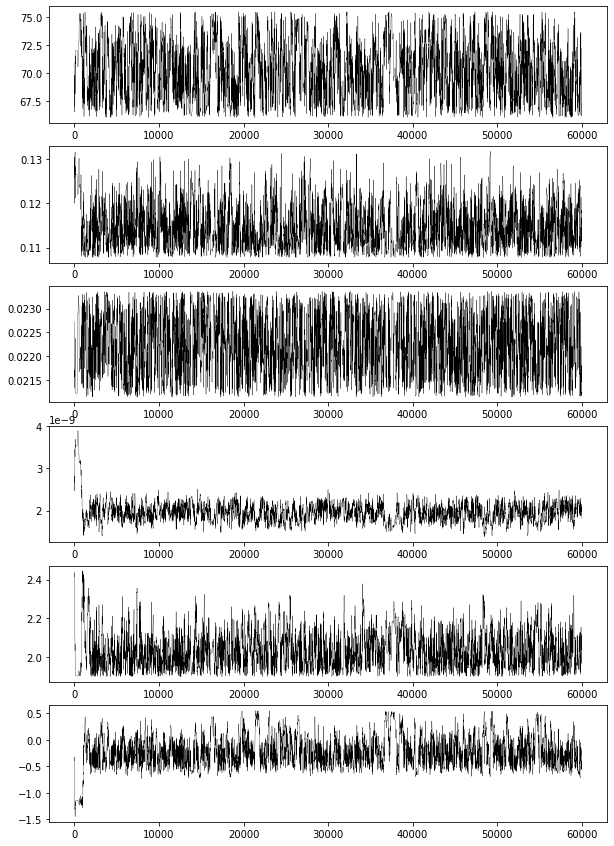

In [9]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain_varied_C[:N_sub,i].T, 'k-', lw=0.3)
plt.show()  

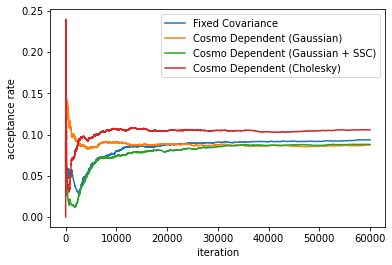

In [10]:
plt.plot(range(N)[10:N_sub], rate_T0[10:N_sub], label="Fixed Covariance")
plt.plot(range(N)[10:N_sub], rate_varied_G[10:N_sub], label="Cosmo Dependent (Gaussian)")
plt.plot(range(N)[10:N_sub], rate_varied_SSC[10:N_sub], label="Cosmo Dependent (Gaussian + SSC)")
plt.plot(range(N)[10:N_sub], rate_varied_C[10:N_sub], label="Cosmo Dependent (Cholesky)")
plt.xlabel("iteration")
plt.ylabel("acceptance rate")
plt.legend()

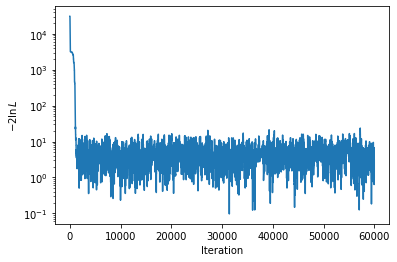

In [11]:
plt.plot(range(N)[:N_sub], -2*lkl_varied_C[:N_sub])
plt.xlabel("Iteration")
plt.ylabel(r"$-2 \ln{L}$")
plt.yscale("log")

In [12]:
C_theta = np.cov(chain_varied_C[4200:N_sub], rowvar=False)
for i in range(C_theta.shape[0]):
    print("[",end =" ")
    for j in range(C_theta.shape[1]):
        print(str(C_theta[i,j]) + ",",end =" ")
    print("],")
    
for i in range(6):
    print(np.sqrt(C_theta[i,i]))

[ 6.628790387511585, -0.0030239282139277366, -2.9349402925838873e-05, -3.2729946400670026e-10, -0.01924118996160233, 0.4979675594579998, ],
[ -0.0030239282139277366, 2.522743409468222e-05, 8.737596798713773e-08, 1.5542135149105425e-13, -0.0001744523157173409, -0.000921860605647122, ],
[ -2.9349402925838873e-05, 8.737596798713773e-08, 4.1436593424454094e-07, 1.373829390161128e-14, -1.4133926336119427e-06, 2.008523468343532e-08, ],
[ -3.2729946400670026e-10, 1.5542135149105425e-13, 1.373829390161128e-14, 4.089236570500101e-20, -1.1307853694926036e-11, -4.485211658546638e-11, ],
[ -0.01924118996160233, -0.0001744523157173409, -1.4133926336119427e-06, -1.1307853694926036e-11, 0.007959153243599389, 0.01308480714852781, ],
[ 0.4979675594579998, -0.000921860605647122, 2.008523468343532e-08, -4.485211658546638e-11, 0.01308480714852781, 0.0854320519510707, ],
2.5746437399204547
0.0050226919171577926
0.0006437126177453266
2.0221860870108124e-10
0.0892140865760525
0.2922876185387789


In [13]:
N_BURN_IN = 4200

samples_fixed = chain_fixed[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_fixed_far = chain_fixed_far[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G = chain_varied_G[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G_emulated = chain_varied_G_emulated[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_SSC = chain_varied_SSC[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_C = chain_varied_C[N_BURN_IN:N_sub, :].reshape((-1,NDIM))

## Figure of Merit Code  
The Figure of Merit is defined in https://www.nsf.gov/mps/ast/aaac/dark_energy_task_force/report/detf_final_report.pdf as  
$$ FoM = \sqrt{det(C_{\theta_i, \theta_j}^{-1})} $$  
Where C is the covariance matrix of 2 parameters $\theta_i$ and $\theta_j$ in a given MCMC chain (late time). Normally this stat is used for $w_0$ and $w_a$, but it can technically be used for any pair of parameters you are scanning over.

In [14]:
def FoM(param_1, param_2):
    chain_1 = np.vstack((chain_fixed[10000:N_sub, param_1], chain_fixed[10000:N_sub, param_2])).T
    chain_2 = np.vstack((chain_varied_C[10000:N_sub, param_1], chain_varied_C[10000:N_sub, param_2])).T

    num_bins = 15
    FoM_1, FoM_2 = np.zeros(num_bins), np.zeros(num_bins)
    chain_len_1, chain_len_2 = chain_1.shape[0], chain_2.shape[0]
    for b in range(num_bins):
        subchain_1 = chain_1[b*int(chain_len_1 / num_bins):(b+1)*int(chain_len_1 / num_bins), :]
        subchain_2 = chain_2[b*int(chain_len_2 / num_bins):(b+1)*int(chain_len_2 / num_bins), :]

        # calculate the covariance matrix of this subchain
        cov_1 = np.cov(subchain_1, rowvar=False)
        cov_2 = np.cov(subchain_2, rowvar=False)
        FoM_1[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_1)))
        FoM_2[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))

    # Calculate the FoM for the last 30% of the chain
    cov_1 = np.cov(chain_1[int(0.7*chain_len_1):,:], rowvar=False)
    cov_2 = np.cov(chain_2[int(0.7*chain_len_2):,:], rowvar=False)
    FoM_30 = [np.sqrt(np.linalg.det(np.linalg.inv(cov_1))), np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))]
    
    return FoM_1, FoM_2, FoM_30

/tmp/ipykernel_38587/4256885081.py:25: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))


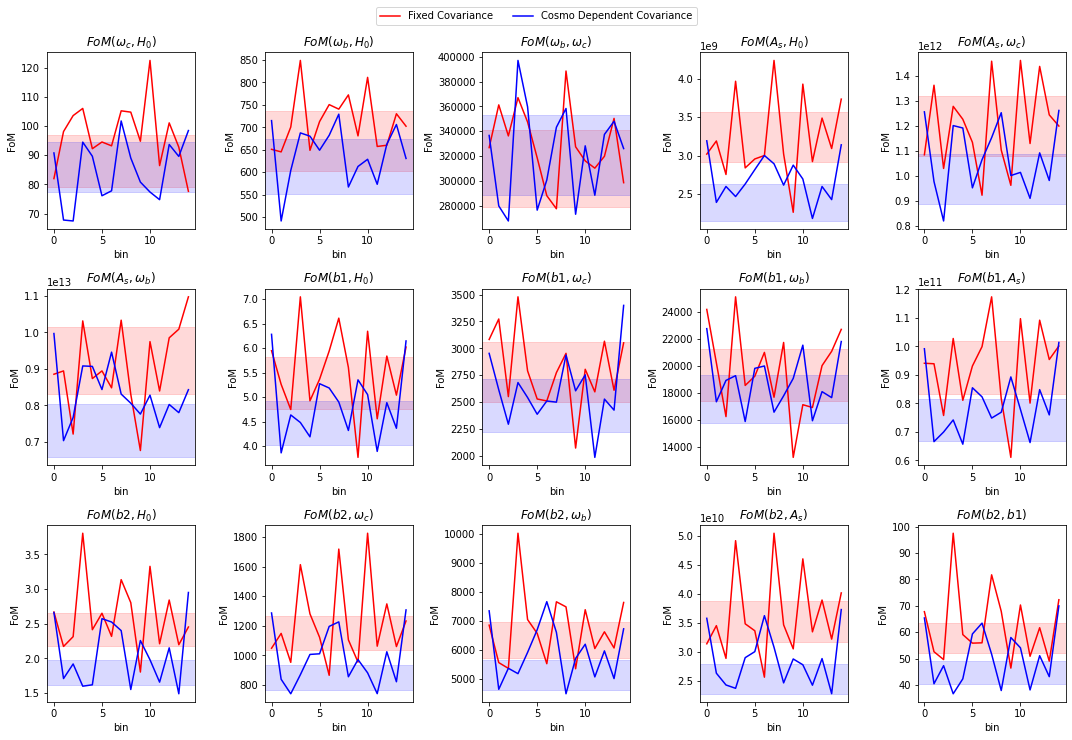

In [15]:
fig, axs = plt.subplots(3, 5, figsize=(15,10))
labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
num_bins = 15
idx = 0
ax_list = axs.ravel()
for i in range(6):
    for j in range(6):
        if j >= i:
            continue
        FoM_1, FoM_2, FoM_30 = FoM(i, j)
        ax_list[idx].set_title(r"$FoM(" + labels[i] + ", " + labels[j] + ")$")
        l1 = ax_list[idx].plot(range(num_bins), FoM_1, c="red")
        l2 = ax_list[idx].plot(range(num_bins), FoM_2, c="blue")

        h1 = ax_list[idx].axhspan(FoM_30[0]*0.9, FoM_30[0]*1.1, color="red", alpha=0.15)
        h2 = ax_list[idx].axhspan(FoM_30[1]*0.9, FoM_30[1]*1.1, color="blue", alpha=0.15)
        
        #ax[0].set_yscale("log")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_ylabel("FoM")

        idx+= 1
        
fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))
plt.tight_layout()

In [16]:
def plot_cosmo_contours(sample_list, legend_labels, num_plots):
    names = ['H0', 'omegac', 'omegab', 'As', 'b1', 'b2']
    labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
    
    #cosmo_truth = [69., 0.1199772, 0.0228528, 2e-9, 1.9485, -0.5386]
    cosmo_truth = [67.8, 0.1190, 0.02215, 2.207e-9, 2.01, -0.47]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples_1, getdist_samples_2 = [],[]
    label = labels[:num_plots]
    name = names[:num_plots]
    getdist_samples = []
    for i in range(len(legend_labels)):
        getdist_samples.append(MCSamples(samples=sample_list[i][:,:num_plots], names = name, labels=label, label=legend_labels[i]))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=False, markers=truth_dict)
    
    plt.show()

Removed no burn in
Removed no burn in


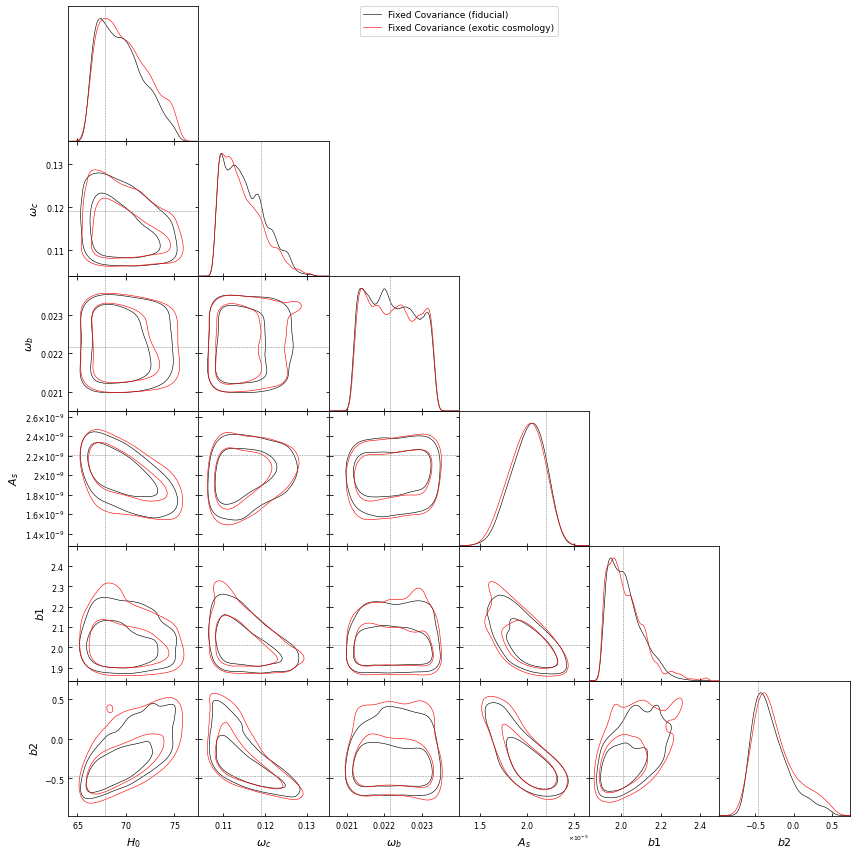

In [17]:
plot_cosmo_contours([samples_fixed, samples_fixed_far], ["Fixed Covariance (fiducial)", "Fixed Covariance (exotic cosmology)"],6)

Removed no burn in
Removed no burn in


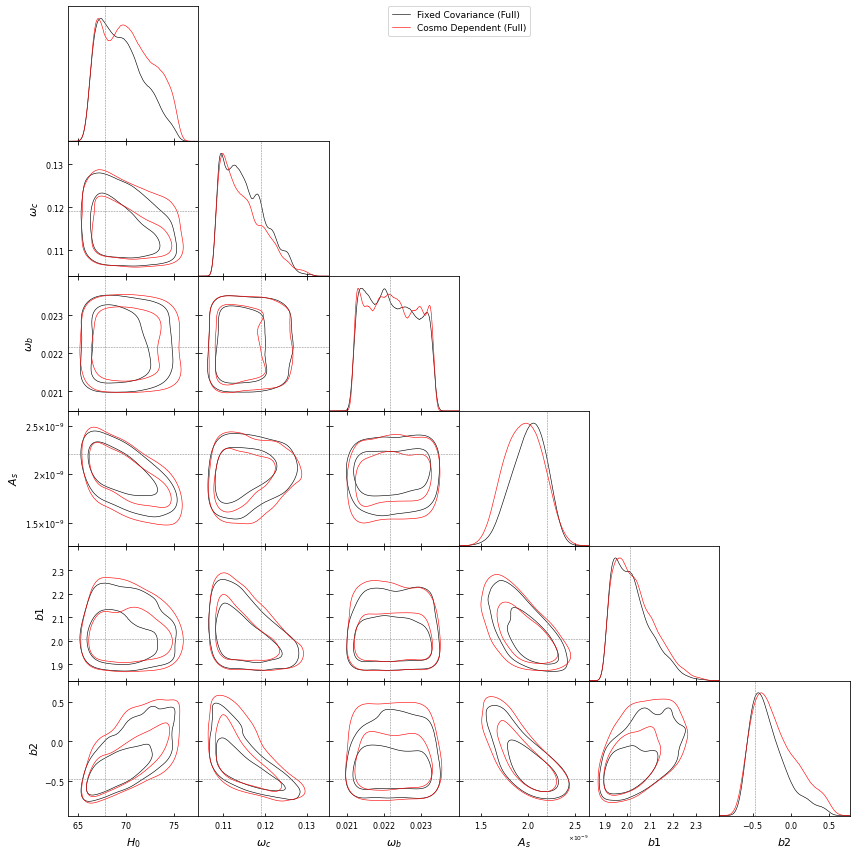

In [20]:
plot_cosmo_contours([samples_fixed, samples_varied_C], ["Fixed Covariance (Full)", "Cosmo Dependent (Full)"],6)

Removed no burn in
Removed no burn in
Removed no burn in


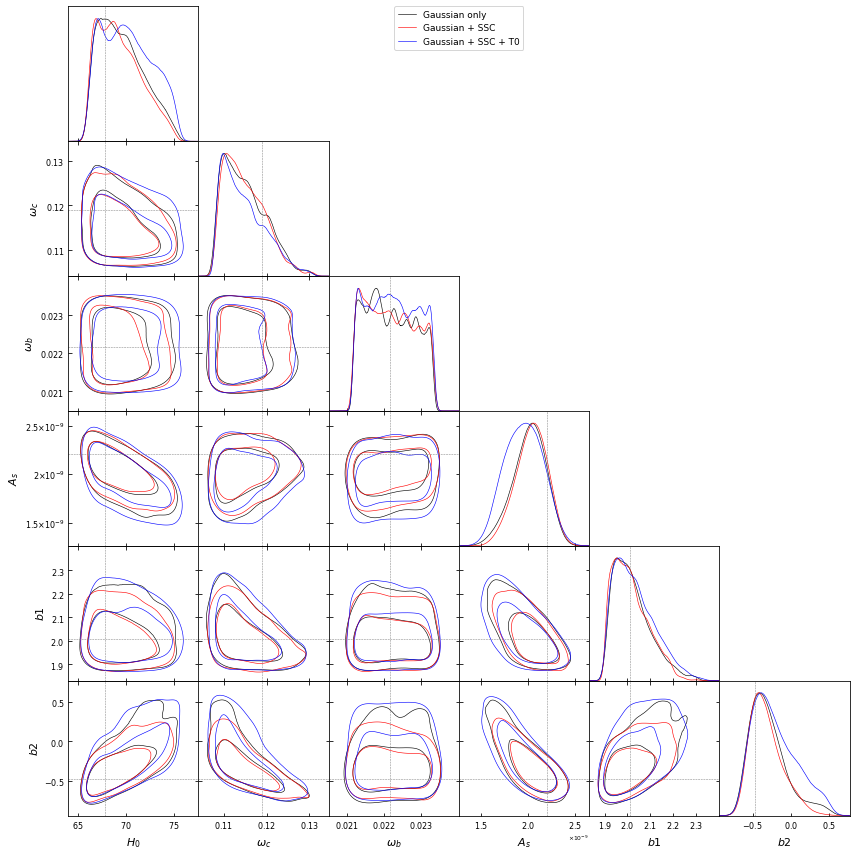

In [21]:
plot_cosmo_contours([samples_varied_G, samples_varied_SSC, samples_varied_C], ["Gaussian only", "Gaussian + SSC", "Gaussian + SSC + T0"],6)

Removed no burn in
Removed no burn in


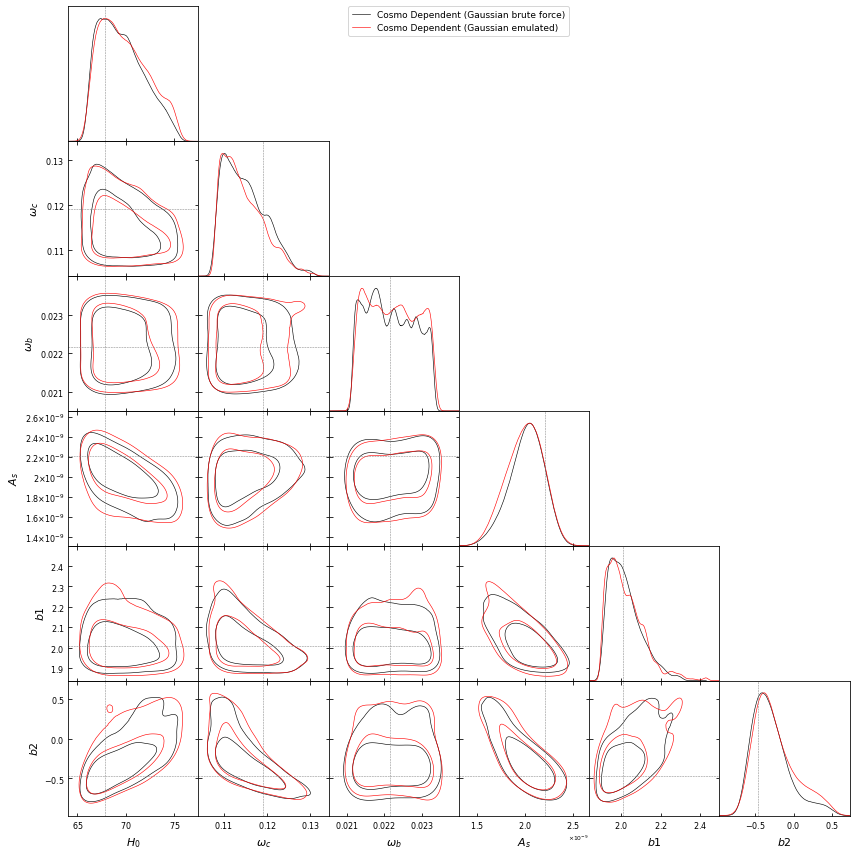

In [20]:
plot_cosmo_contours([samples_varied_G, samples_varied_G_emulated], ["Cosmo Dependent (Gaussian brute force)", "Cosmo Dependent (Gaussian emulated)"],6)

## MultiNest Code

  analysing data from /home/joeadamo/Research/CovNet/chains/T0-.txt
  analysing data from /home/joeadamo/Research/CovNet/chains/No-T0-.txt


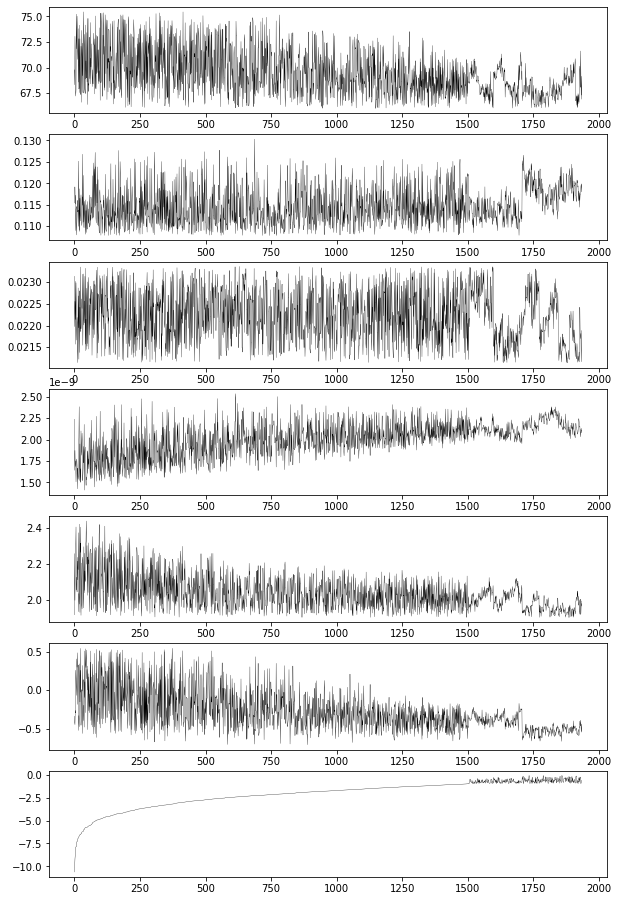

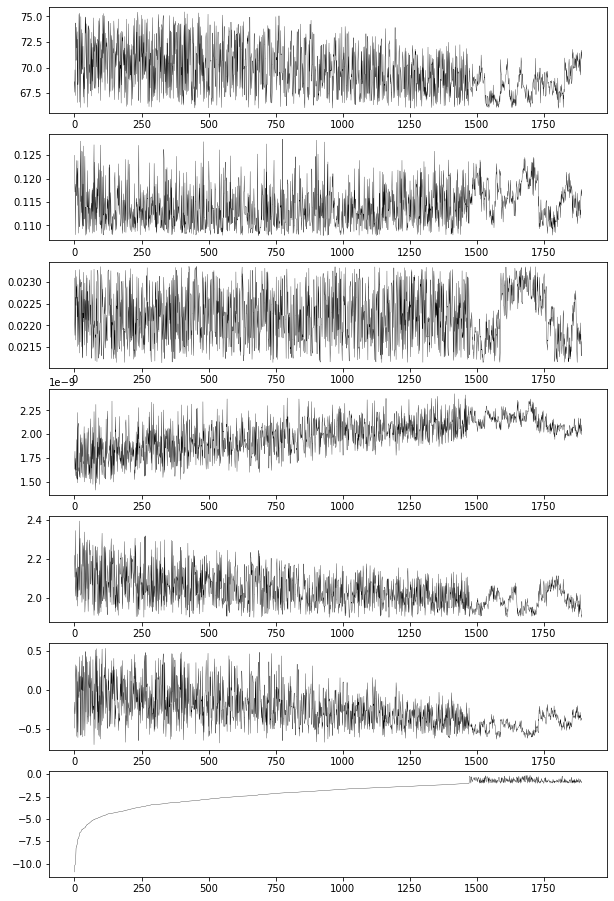

In [18]:
#import pymultinest
chains_dir = "/home/joeadamo/Research/CovNet/chains/"
prefix = ["T0-", "No-T0-"]
parameters = ["H0", "omch2","ombh2", "As","b1","b2"]
n_params=6
# lets analyse the results
a_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[0])
a_no_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[1])
#s = a.get_stats()

# This takes the end of the chain calculated by multinest
chain_Mult_T0 = a_T0.get_equal_weighted_posterior()
chain_Mult_no_T0 = a_no_T0.get_equal_weighted_posterior()

chain_Mult_T0[:,3] = np.exp(chain_Mult_T0[:,3]) / 1e10
chain_Mult_no_T0[:,3] = np.exp(chain_Mult_no_T0[:,3]) / 1e10
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_Mult_T0[:,i], 'k-', lw=0.3)
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(7):
    ax[i].plot(chain_Mult_no_T0[:,i], 'k-', lw=0.3)
plt.show()

In [19]:
N_BURN_IN = 10
cosmo_truth = [67.8,0.1190,0.02215,3.094,1.9485,-0.538]
cosmo_fid = np.array([67.8,0.1190,0.02215,3.094,1.9485,-0.5387])
Omega_b = 0.048206; h = cosmo_fid[0] / 100.
Omega_m = 0.307115
#model the cholesky decomposition
#double check how I canclulate H0
#compare C with other emulators
#samples_fixed = chain_fixed[N_BURN_IN:, :].reshape((-1,NDIM))
# look into what the consensus is for using the T0 term <- can look at this in the simulation case as well
samples_1 = chain_Mult_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
samples_2 = chain_Mult_no_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
plot_cosmo_contours(samples_2, samples_1, [ "No T0 term", 'Full Covariance'], 6)
#plot_cosmo_contours(samples_2, samples_2, [ "No T0 term", "No T0 term"], 6

TypeError: plot_cosmo_contours() takes 3 positional arguments but 4 were given

In [ ]:
# print("\tFull Covariance\t\t\tNo T0")

# # print(str(parameters[0])+":\t {:0.2f} +- {:0.2f}\t\t\t {:0.2f} +- {:0.2f}".format(np.mean(chain_fixed[:,0]), np.std(chain_fixed[:,0]), np.mean(chain_no_T0[:,0]), np.std(chain_no_T0[:,0])))
# # print(str(parameters[1])+":\t {:0.4f} +- {:0.4f}\t\t {:0.4f} +- {:0.4f}".format(np.mean(chain_fixed[:,1]), np.std(chain_fixed[:,1]), np.mean(chain_no_T0[:,1]), np.std(chain_no_T0[:,1])))
# # print(str(parameters[2])+":\t {:0.5f} +- {:0.5f}\t\t {:0.5f} +- {:0.5f}".format(np.mean(chain_fixed[:,2]), np.std(chain_fixed[:,2]), np.mean(chain_no_T0[:,2]), np.std(chain_no_T0[:,2])))
# # print(str(parameters[3])+":\t {:0.2e} +- {:0.2e}\t\t {:0.2e} +- {:0.2e}".format(np.mean(chain_fixed[:,3]), np.std(chain_fixed[:,3]), np.mean(chain_no_T0[:,3]), np.std(chain_no_T0[:,3])))
# # print(str(parameters[4])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,4]), np.std(chain_fixed[:,4]), np.mean(chain_no_T0[:,4]), np.std(chain_no_T0[:,4])))
# # print(str(parameters[5])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,5]), np.std(chain_fixed[:,5]), np.mean(chain_no_T0[:,5]), np.std(chain_no_T0[:,5])))

# for i in range(6):
#     print("shift: {:0.3f} sigma".format((abs(np.mean(chain_fixed[:,i]) - np.mean(chain_no_T0[:,i])) / np.std(chain_fixed[:,i]))))